# Chapter 9. Extensions

Compute and plot the numerical results of Section 9.2. The commented code is in charge of loading simulation results that might be added later.

## Package imports and global variable definitions

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# uncomment this line if you prefer dynamic matplotlib plots
# %matplotlib notebook

# change the default figure size
# pylab.rcParams['figure.figsize'] = (10.0, 6.0)
pylab.rcParams['legend.fontsize'] = 12

In [3]:
# manipulate dataframes
import pandas as pd

In [4]:
# useful in the function dynamic
from scipy import special

In [5]:
# global variables
ρρ = linspace(4., 0, 50, endpoint = False)
N = 10
μ = 1.

## Function definitions

All numerical results are for two dispatchers only.

### Single dispatcher

In [6]:
def single_dispatcher(l, μ, ν):
    # parameters
    I = len(l)
    barℓ = zeros(I, dtype=int)
    barℓ[1:] = cumsum(ℓ[:-1])
    
    # initialization: π_0
    π = ones(1, dtype=float64)
    
    for i in range(I):
        # recursion:  derive π_{i+1} from π_i
        
        # compute p_{i+1}
        p = ones(ℓ[i] + 1, dtype=float64)
        p[1:] = cumprod(μ[i] / (ν * arange(1, ℓ[i]+1)), dtype=float64)
        
        # make the outer product of π_i with p_{i+1}
        π = outer(π, p[::-1])
        
        # multiply each coefficient by t! / s!
        for s in range(barℓ[i] + 1):
            quotient = ones(ℓ[i] + 1, dtype=float64)
            quotient[1:] = cumprod(s + arange(1, ℓ[i] + 1), dtype=float64)
            π[s] *= quotient[::-1]
        
        # sum over the (anti)diagonals
        π = [trace(π, n) for n in range(ℓ[i], -barℓ[i] - 1, -1)]
    
    return 1. / sum(π)

### Multiple dispatchers with a static routing

In [7]:
def multi_dispatcher_static(l, α, β):
    maxl = max(l)
    cuml = cumsum(l)
    
    αs = ones(maxl+1, dtype=float64)
    αs[1:] = cumprod(α / arange(1, maxl+1))
    
    βt = ones(maxl+1, dtype=float64)
    βt[1:] = cumprod(β / arange(1, maxl+1))
    
    # i = 0
    oldG = outer(α**arange(l[0]+1), β**arange(l[0]+1)) * (tri(l[0]+1)[::-1])
    
    # i > 0
    for i in range(1, len(l)):
        G = zeros((cuml[i]+1, cuml[i]+1), dtype=float64)
        
        for ps in range(cuml[i-1]+1):
            for pt in range(cuml[i-1]-ps+1):
                prods = float64(1.)
                for s in range(ps, ps+l[i]+1):
                    prodt = float64(1.)
                    for t in range(pt, pt+l[i]-(s-ps)+1):
                        G[s,t] += oldG[ps, pt] * αs[s-ps] * βt[t-pt] * prods * prodt
                        prodt *= (t+1)
                    prods *= (s+1)
        
        oldG = copy(G)
    
    return sum(sum(G))

### Multple dispatchers with a dynamic routing

In [8]:
def dynamic(N, l, α, β):
    q = l // 2
    
    αs = ones(q+1, dtype=float64)
    αs[1:] = cumprod(α / arange(1, q+1))
    
    βt = ones(q+1, dtype=float64)
    βt[1:] = cumprod(β / arange(1, q+1))
    
    coeff = ones((q+1,q+1))
    for y in range(q+1):
        for z in range(q+1):
            coeff[y,z] = special.binom(l-y-z, q-y)
    
    # i = 0
    oldG = outer(α**arange(l+1), β**arange(l+1)) * (tri(l+1)[::-1])
    oldG = oldG[:q+1,:q+1] * coeff
    
    # i > 0
    for i in range(1, N):
        G = zeros((q*(i+1)+1, q*(i+1)+1), dtype=float64)
        
        for ps in range(q*i+1):
            for pt in range(min(q*i, l*i-ps) + 1):
                prods = float64(1.)
                for s in range(ps, ps + q + 1):
                    prodt = float64(1.)
                    for t in range(pt, pt + min(q,l-(s-ps)) + 1):
                        G[s,t] += oldG[ps, pt] * αs[s-ps] * βt[t-pt] * prods * prodt * coeff[s-ps,t-pt]
                        prodt *= (t+1)
                    prods *= (s+1)
        
        oldG = copy(G)
    
    return sum(sum(G))

## Numerical results

### Balanced arrivals

In [9]:
# parameters
ll = [2,4,6]
α1 = .5 # proportion of arrivals at dispatcher 1
p1 = .5 # routing probabilities of tokens to dispatcher 1

In [10]:
static_result = []
for l in ll:
    static_result.append([
        (
            (1-α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
            + α1 / single_dispatcher(l * ones(N, dtype=int), (1-p1) * μ * ones(N), (1-α1) * N * μ * ρ)
        )
        / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1-p1) / ((1-α1)*N*ρ)) for ρ in ρρ
    ])

In [11]:
dynamic_result = []
for l in ll:
    dynamic_result.append([
        (
            (1-α1) * dynamic(N, l, 1. / (α1*N*ρ), 0.)
            + α1 * dynamic(N, l, 0., 1. / ((1-α1)*N*ρ))
        )
        / dynamic(N, l, 1. / (α1*N*ρ), 1. / ((1-α1)*N*ρ))
        for ρ in ρρ
    ])

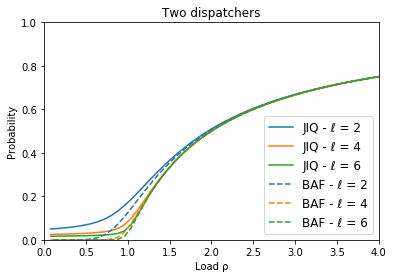

In [12]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, static_result[i], label = "JIQ - ℓ = " + str(l))

for i,l in enumerate(ll):
    plot(ρρ, dynamic_result[i], '--', color = 'C'+str(i), label = "BAF - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="JIQ - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-balanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="BAF - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Imbalanced arrivals

In [13]:
# parameters
ll = [2,4,6]
α1 = .8 # proportion of arrivals at dispatcher 1

In [14]:
p1 = .5 # routing probabilities of tokens to dispatcher 1

uniform_static_result = []
for l in ll:
    uniform_static_result.append([
        (
            (1-α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
            + α1 / single_dispatcher(l * ones(N, dtype=int), (1-p1) * μ * ones(N), (1-α1) * N * μ * ρ)
        )
        / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1-p1) / ((1-α1)*N*ρ)) for ρ in ρρ
    ])

In [15]:
p1 = α1 # routing probabilities of tokens to dispatcher 1

best_static_result = []
for l in ll:
    best_static_result.append([
        (
            (1-α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
            + α1 / single_dispatcher(l * ones(N, dtype=int), (1-p1) * μ * ones(N), (1-α1) * N * μ * ρ)
        )
        / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1-p1) / ((1-α1)*N*ρ)) for ρ in ρρ
    ])

In [16]:
dynamic_result = []
for l in ll:
    dynamic_result.append([
        (
            (1-α1) * dynamic(N, l, 1. / (α1*N*ρ), 0.)
            + α1 * dynamic(N, l, 0., 1. / ((1-α1)*N*ρ))
        )
        / dynamic(N, l, 1. / (α1*N*ρ), 1. / ((1-α1)*N*ρ))
        for ρ in ρρ
    ])

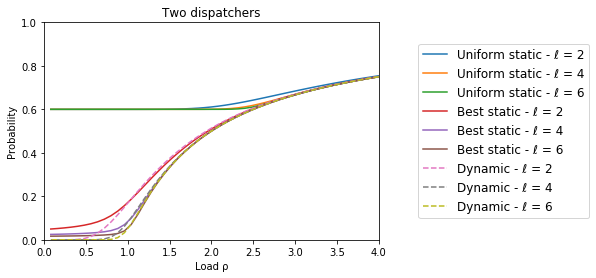

In [17]:
# plot
for i,l in enumerate(ll):
    plot(ρρ, uniform_static_result[i], label = "Uniform static - ℓ = " + str(l))
    
for i,l in enumerate(ll):
    plot(ρρ, best_static_result[i], label = "Best static - ℓ = " + str(l))

for i,l in enumerate(ll):
    plot(ρρ, dynamic_result[i], '--', label = "Dynamic - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/dispatchers' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="x", label="JIQ - ℓ = " + str(l))

#for i,l in enumerate(ll):
#    ρρρ, exp_blocking \
#    = loadtxt('data/baf' + str(l) + '-imbalanced-blocking', delimiter='\t', unpack=True)
#    plot(ρρρ, exp_blocking, color = 'C' + str(i), linestyle="None", marker="+", label="BAF - ℓ = " + str(l))

xlim(0,4); ylim(0,1)
legend(loc=6, bbox_to_anchor=(1.1, .5)); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Homogeneous

In [18]:
# parameters
l = 6
α1 = .5 # proportion of arrivals at dispatcher 1

In [19]:
p1 = .5 # routing probabilities of tokens to dispatcher 1

best_static_result = [ (
    (1-α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
    + α1 / single_dispatcher(l * ones(N, dtype=int), (1-p1) * μ * ones(N), (1-α1) * N * μ * ρ)
) / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1-p1) / ((1-α1)*N*ρ)) for ρ in ρρ ]

In [20]:
dynamic_result = [ (
    (1-α1) * dynamic(N, l, 1. / (α1*N*ρ), 0.)
    + α1 * dynamic(N, l, 0., 1. / ((1-α1)*N*ρ))
) / dynamic(N, l, 1. / (α1*N*ρ), 1. / ((1-α1)*N*ρ)) for ρ in ρρ ]

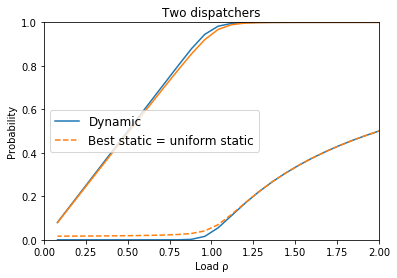

In [21]:
# plot
plot(ρρ, dynamic_result, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic_result], color = 'C0')
plot(ρρ, best_static_result, '--', color = 'C1', label = "Best static = uniform static")
plot(ρρ, ρρ * [1. - β for β in best_static_result], color = 'C1')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="+", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-homo-static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="x", label="Best static")

xlim(0,2); ylim(0,1)
legend(loc='best'); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

### Heterogeneous

In [22]:
# parameters
l = 6
α1 = .8 # proportion of arrivals at dispatcher 1

In [23]:
p1 = .5 # routing probabilities of tokens to dispatcher 1

uniform_static_result = [ (
    (1-α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
    + α1 / single_dispatcher(l * ones(N, dtype=int), (1-p1) * μ * ones(N), (1-α1) * N * μ * ρ)
) / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1-p1) / ((1-α1)*N*ρ)) for ρ in ρρ ]

In [24]:
p1 = .8 # routing probabilities of tokens to dispatcher 1

best_static_result = [ (
    (1 - α1) / single_dispatcher(l * ones(N, dtype=int), p1 * μ * ones(N), α1 * N * μ * ρ)
    + α1 / single_dispatcher(l * ones(N, dtype=int), (1 - p1) * μ * ones(N), (1 - α1) * N * μ * ρ)
) / multi_dispatcher_static(l * ones(N, dtype=int), p1 / (α1*N*ρ), (1 - p1) / ((1 - α1) * N * ρ)) for ρ in ρρ ]

In [25]:
dynamic_result = [ (
    (1 - α1) * dynamic(N, l, 1. / (α1 * N * ρ), 0.)
    + α1 * dynamic(N, l, 0., 1. / ((1 - α1) * N * ρ))
) / dynamic(N, l, 1. / (α1 * N * ρ), 1. / ((1 - α1) * N * ρ)) for ρ in ρρ ]

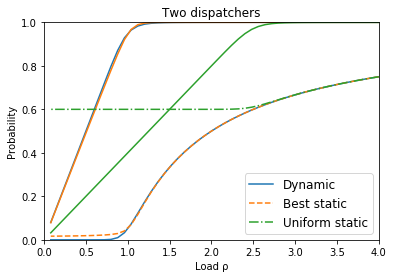

In [26]:
# plot
plot(ρρ, dynamic_result, color = 'C0', label = "Dynamic")
plot(ρρ, ρρ * [1. - β for β in dynamic_result], color = 'C0')
plot(ρρ, best_static_result, '--', color = 'C1', label = "Best static")
plot(ρρ, ρρ * [1. - β for β in best_static_result], color = 'C1')
plot(ρρ, uniform_static_result, '-.', color = 'C2', label = 'Uniform static')
plot(ρρ, ρρ * [1. - β for β in uniform_static_result], color = 'C2')

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-dynamic-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C0', linestyle="None", marker="x", label="Dynamic")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-best_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C1', linestyle="None", marker="+", label="Best static")

#ρρρ, exp_blocking \
#= loadtxt('data/dispatchers' + str(l) + '-hete-uniform_static-blocking', delimiter='\t', unpack=True)
#plot(ρρρ, exp_blocking, color = 'C2', linestyle="None", marker="x", label="uniform_static static")

xlim(0,4); ylim(0,1)
legend(loc=4); title("Two dispatchers")
xlabel("Load ρ"); ylabel("Probability")
show()

In [27]:
# save
df = pd.DataFrame({'rho': ρρ,
                    'db': dynamic_result,
                    'do': ρρ * [1. - β for β in dynamic_result],
                    'ob': best_static_result,
                    'oo': ρρ * [1. - β for β in best_static_result],
                    'ub': uniform_static_result,
                    'uo': ρρ * [1. - β for β in uniform_static_result]
                    })

fn = "data/theo-jiq-comp.csv"
df.to_csv(fn, index = False)